# 2D RAY TRACER
[Link to video presentation!](https://youtu.be/YHWGXTXDmJY)

---


This colab notebook implements a basic 2D ray tracer to simulate the behavior of light rays as they interact with circular objects including Luneburg lenses that have radially varying refractive indices. The ray tracer accounts for both reflection and refraction and displays the paths of the light rays as they travel through the scene. The idea for this notebook was inspired by [this ray optics simulator](https://phydemo.app/ray-optics/simulator/).

---

Features:
*   The ray tracer can generate rays from two different types of light sources: directional lights where all rays are parallel, and spot lights where rays are emitted in a cone from a given origin.
*   Each ray can bounce multiple times, reflecting and refracting off surfaces until a specified bounce limit is reached, the ray runs out of 'energy', or the ray exits the scene.
*   Luneburg lenses are also modelled which have radially varying indices of refraction causing light rays to bend as they pass through.
*   The visualizations showcase the intricate patterns formed due to multiple reflections, refractions, and the curvation of light.

The cells below will walk you through the all the steps required for this particular ray tracer including things like how ray-circle intersections are handled, how to reflect and refract rays, how to model luneburg lenses, and how we handled initializing rays and rendering the final result.

In [ ]:
# Import required libraries: numpy for calculations, and pyplot for plotting the scene
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

#Defining Rays, Hits, and Objects (in this case, circles)

### Ray
A given light ray is an instance of the Ray class, and it travels linearly through space from a specified point. Its variables are:
*   **`[o]rigin`:** the point on the plot from which the ray originates
*   **`[d]irection`:** the 2D unit vector corresponding to its direction through space
*   **`[e]nd`:** the endpoint of the ray (i.e., the hit point of closest intersection, if any)
*   **`color`:** the color the ray is drawn on screen, defaulted to red
*   **`bounce`:** the number of times the ray has intersected with an object upto this point in its path
*   **`energy`:** the *remaining* energy of the ray -- it is initialized to 1 and decreases as the ray traverses the scene
  * Note: the energy is also used in rendering to determine the opacity of the ray.
*   **`eta`:** the index of refraction of the material that the ray is currently in
*   **`luneburg`:** a boolean indicating if the ray is within a Luneburg lens. If it is, it should be drawn with half opacity since adjacent intermediate rays within luneburg lenses will overlap.

### Hit
When a ray intersects an object, the intersection is stored as a hit which stores various pieces of information regarding the interaction:
*   **`t`:** the length the ray travels before intersecting the object. It is essentially how many times the ray travels along the unit direction vector before hitting the object.
*   **`[p]osition`:** a numpy array representing the 2D position in world space where the ray intersected the object
*   **`[n]ormal`:** a numpy array representing the 2D surface normal of the object at the intersection point
*   **`eta`:** the index of refraction of the material that the ray intersected
  * Note: mirror surfaces are represented by setting eta = 0
*   **`circle`:** only used for Luneburg lenses, we store the entire circle for use within the Luneburg lens tracing code

### Circle
A circle that's drawn on the plot for the rays to interact with is an instance of the Circle class. Its variables are:
*   **`center`:** a numpy array representing the center of the circle
*   **`radius`:** the scalar corresponding to the circle's radius
*   **`eta`:** the index of refraction of the circle
*   **`p`:** for non-continuous refractive index lenses, the Luneburg lens variable $p$ (more on this later)
*   **`color`:** the color of the circle, default to blue.

In [ ]:
# Set a non-inf "inf" value so we can still plot the lines
INF = 1e8

# Small epsilon for avoiding numerical precision errors
epsilon = 1e-8

class Ray:
  def __init__(self, origin, direction, end = np.array([0, 0]), energy = 1.0, bounce = 0, color = np.array([1.0, 0.0, 0.0]), eta = 1, luneburg = False):
    self.o = origin
    self.d = direction
    self.e = end
    self.color = color
    self.bounce = bounce
    self.energy = energy
    self.eta = eta
    self.luneburg = luneburg

class Hit:
  def __init__(self, t = INF, position = np.array([0,0]), normal = np.array([0,0]), eta = 1, circle = None):
    self.t = t
    self.p = position
    self.n = normal
    self.eta = eta
    self.circle = circle

class Circle:
  def __init__(self, center, radius, eta = 0, p = 0, color = [0,0.3,0.5,0.5]):
    self.c = center
    self.r = radius
    self.eta = eta
    self.p = p
    self.color = color

#Ray-Circle Intersection:
The function `circleIntersect` computes the points where a ray intersects a circle, if any. Then returns a hit for the closest intersection. This uses the equation of a circle and the parametric equations of a ray:

$$(x-a)^2 + (y-b)^2 = r^2$$
$$x = x_0 + x_dt$$
$$y = y_0 + y_dt$$

where $a, b$ are the position of the circle, $x_0, y_0$ are the origin of the ray and $x_d, y_d$ are the $x$ and $y$ components of the unit direction vector. We can then solve these equations for $t$ using the quadratic formula which we solve using `poly.polyroots`.

###Parameters:

*  **`ray`:** The ray for which intersections with the circle are to be found.
*  **`circle`:** The circle being checked for intersections.

###Functionality:

*   **Quadratic Equation:**
The intersection of a ray and a circle can be found by substituting the parametric equation of the ray into the equation of the circle and solving for the parameter $t$. This results in a quadratic equation of the form:
$$At^2+Bt+C=0$$
where
  * $A = a^2 + b^2$
  * $B = 2(ax_d + by_d)$
  * $C = x_d^2 + y_d^2 - r^2$

*   **Solving for $t$:**
The quadratic equation is solved to get the potential values of $t$, which indicate how far along the ray the intersections occur.
   *   There can be three scenarios:
      *   *Two real solutions:* The ray intersects the circle at two distinct points.
      *   *One real solution:* The ray is tangent to the circle, touching it at a single point.
      *   *No real solution:* The ray does not intersect the circle.

###Returns:

A hit structure containing information on the closest intersection, if any.

In [ ]:
# Return closest hit for ray-circle intersection
# (x - a)^2 + (y - b)^2 = r^2
# x = x0 + xd*t, y = y0 + yd*t
# solve quadratic equation for t
def circleIntersect(ray, circle, circles):

  # Determine coefficients A, B, and C
  a = ray.d[0]
  b = ray.d[1]
  A = a*a + b*b

  x0 = ray.o[0]
  y0 = ray.o[1]
  xd = x0 - circle.c[0]
  yd = y0 - circle.c[1]
  B = 2 * (a*xd + b*yd)

  C = xd*xd + yd*yd - circle.r*circle.r

  # Solve the quadratic formula
  intersects = poly.polyroots([C, B, A])

  # Find the closest positive (real) intersection, if any exist
  # Note: polyroots can return non-real solutions too, but, in this context it means the ray missed the circle
  intersects = intersects[np.where(np.isreal(intersects))[0]]
  if np.size(intersects) > 0: intersects = intersects[np.where(intersects > 0)[0]]
  closestIntersect = INF
  for intersect in intersects:
    if intersect < closestIntersect:
      closestIntersect = intersect

  # Create and return the hit
  hit = Hit()
  if closestIntersect < INF:
    hit.t = closestIntersect
    hit.p = ray.o + ray.d * hit.t
    # The normal vector for a circle is the ray from the circle center to the hitpoint
    hit.n = hit.p - circle.c
    hit.n = hit.n / np.linalg.norm(hit.n) # normalize
    if circle.p == 0: # Constant refractive index lenses
      if np.dot(ray.d, hit.n) > 0:
        # If the ray exits into another circle, set hit.eta to be that circle's index of refraction (at the given position)
        hit.eta = getEta(hit.p, circle, circles)
      else:
        hit.eta = circle.eta
    else: # Non-constant refractive index lenses
      hit.circle = circle

  return hit

In [ ]:
# Determine if the exiting ray is within another circle. If so, determine the new index of refraction. Otherwise, return 1 (i.e., assume air)
def getEta(p, currCirc, circles):
  for circle in circles:
    if circle == currCirc: continue # Skip over the the circle the ray is already exiting
    v = p - circle.c # Vector from hitpoint to this circle center
    d = np.linalg.norm(v) # Length of that vector
    if d < circle.r: # If point lies within circle
      if circle.p != 0: # If circle is Luneburg
        return luneburg(circle.p, d, circle.r)
      else: return circle.eta
  return 1

#Specular (Mirror) Reflection
When a ray hits the surface of an object, it can reflect based on the angle of incidence. The direction of the reflected ray is computed using the surface normal and the direction of the incoming ray. It uses the principle that the angle of incidence is equal to the angle of reflection.

The equation used to determine the reflected ray direction is:
$$
\hat{R} = \hat{L} - 2(\hat{N} \cdot \hat{L})\hat{N}
$$
where $\hat{R}$ is the reflected ray, $\hat{L}$ is the incoming ray, and $\hat{N}$ is the surface normal. A good explainer of this equation can be found [here](https://www.fabrizioduroni.it/2017/08/25/how-to-calculate-reflection-vector/) (though note, they input $-\hat{L}$ instead of $\hat{L}$ like we do here).

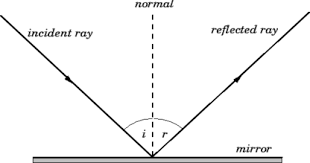

###Parameters:

*  **`ray`:** The incoming ray that hits the surface. Used to get its direction vector and pass on its properties to a new ray.
*  **`hit`:** The hit which is used to determine the origin of the new ray and the surface normal.

###Functionality:

*  **Normalization:**
Both the incoming ray direction and the surface normal are normalized to ensure they have unit length. This is done by dividing the vectors by their length which is calculated using `np.linalg.norm()`.

*  **Bias Addition:**
A small bias is added to the starting point of the reflected ray to prevent it from immediately re-intersecting with the surface due to numerical inaccuracies.
   *   The direction of this bias is determined by the relative orientation of the incoming ray and the surface normal. If the ray intersected from the outside (i.e., the dot product was negative) then the reflected ray should be moved slightly outside. Otherwise, if the ray is internally reflected, the ray is moved slightly inside.
   
###Returns:

The function returns a new `Ray` object that represents the reflected ray, with the updated `origin` (accounting for the bias), an updated bounce count, and the computed reflection `direction`.

In [ ]:
# Calculate reflected ray
def reflect(ray, hit):

  # Normalize the surface normal and ray direction vectors
  hit.n = hit.n / np.linalg.norm(hit.n)
  ray.d = ray.d / np.linalg.norm(ray.d)

  # Determine the cosine of the angle between the normal and the ray direction
  dotProd = np.dot(hit.n, ray.d)

  # Calculate the reflected ray direction
  reflectedDir = ray.d - 2 * dotProd * hit.n
  reflectedDir = reflectedDir / np.linalg.norm(reflectedDir) # normalize

  # To avoid self-reflecting again due to numerical error, we move the ray slightly
  # outside or inside depending on the incoming direction relative to the normal
  bias = hit.n * epsilon
  if dotProd > 0:
    bias *= -1

  # Return the reflected ray
  reflectedRay = Ray(hit.p + bias, reflectedDir, color = ray.color, bounce = ray.bounce + 1, energy = ray.energy, eta = ray.eta)
  return reflectedRay

#Refraction
Refraction occurs when a ray passes from one transparent medium to another with a different refractive index, causing the ray to bend. The bending is dictated by Snell's Law, which relates the angle of incidence, the angle of refraction, and the refractive indices of the two media involved.

The amount of light that is refracted versus the amount that is reflected is determined by the Fresnel equations. There are scenarios where refraction doesn't occur at all due to total internal reflection. In such cases, the ray simply reflects within the same medium.
For more info, take a look at [this tutorial](https://www.scratchapixel.com/lessons/3d-basic-rendering/introduction-to-shading/reflection-refraction-fresnel.html) which goes into the derivation of the refraction equation and Fresnel equations in much more depth.

Below is an example of the Fresnel effect in real life. Here, we see an image of a lake where, close to the camera (i.e., where the angle of incidence is small with respect to the surface normal) we can see right through the surface of the water and as we look farther away (i.e., where the angle of incidence is large with respect to the surface normal), most of the light is reflected showing the mountains in the distance.

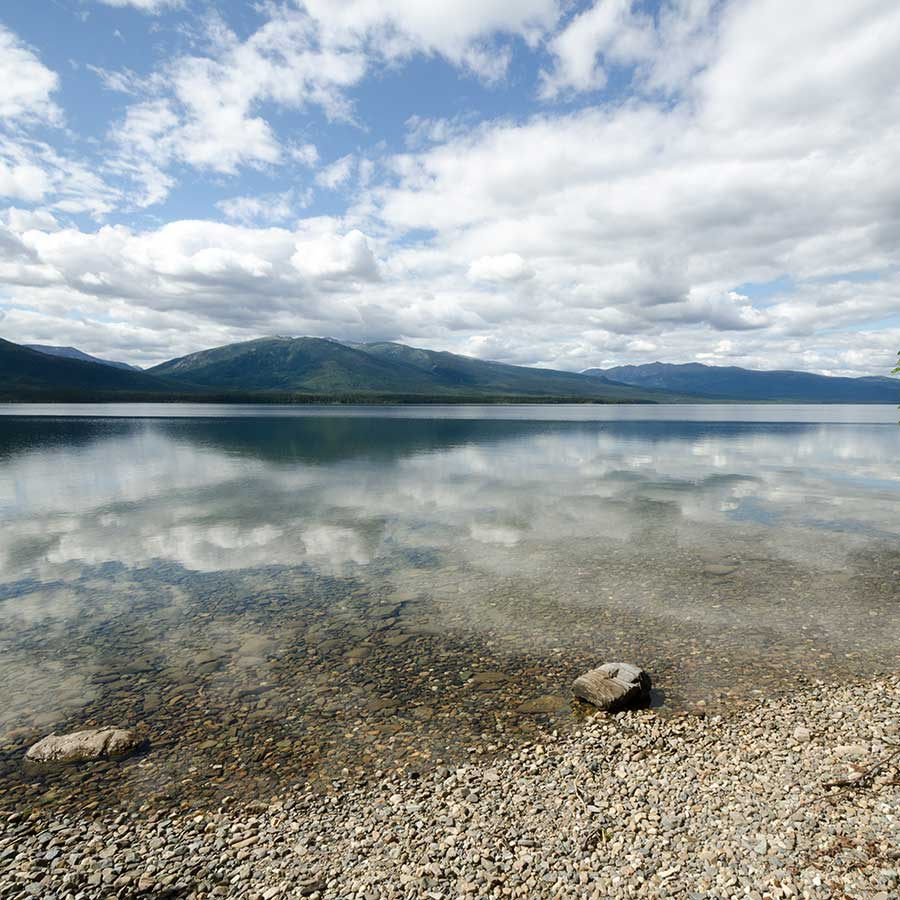

###Parameters:

*   **`ray`:** The incoming ray that enters the transparent surface.
*   **`hit`:** The position and properties of the nearest ray intersection from which the refracted ray will originate.

###Functionality:

*   **Normalization:** Same as with reflection, ensuring the normal and ray direction have unit length.

*   **Inside Check:** The function determines if the ray is inside the transparent object or outside based on the dot product between the ray's direction and the surface normal. If we are outside, we negate the dot product to make it positive, and if we are inside, we flip the normal.

*   **Snell's Law:** The sine of the refraction angle is computed using Snell's Law and Pythagoras's Law.
   *   If the sine squared of the refraction angle is greater than 1, total internal reflection occurs, so the function returns only the reflected ray.

*   **Refraction Calculation:** The refracted direction is computed using the refractive indices and the angle of incidence via the following:

  $\hat{T}_{d} = \eta \hat{I}_{d} + (\eta \cos(\theta_1) - 1 - \sin^2(\theta_2)) \cdot \hat{N}$
  
  where
    * $\hat{T}_{d}$ is the refracted (i.e., transmitted) ray direction
    * $\eta = \frac{n_2}{n_1}$ is the ratio of the index of refraction of the medium the ray in entering $(n_2)$ over the index of refraction of the medium the ray is exiting $(n_1)$
    * $\hat{I}_{d}$ is the incoming ray direction
    * $\theta_1$ is the angle of the incoming ray direction with respect to the surface normal
    * $\theta_2$ is the angle of the transmitted ray with respect to the negative of the surface normal
    * $\hat{N}$ is the surface normal vector

*   **Fresnel Calculation:** When a ray intersects a transparent surface, a portion of the incident light will be reflected and another portion will be refracted (i.e., transmitted). To determine the ratio of reflected $(k_r)$ and refracted $(k_t)$ light, we solve Fresnel's equations:
  
  $k_r = (R_s^2 + R_p^2)/2$

  $R_s = \left| \frac{n_2 \cos(\theta_1) - n_1 \cos(\theta_2)}{n_2 \cos(\theta_1) + n_1 \cos(\theta_2)} \right|^2$

  $R_p = \left| \frac{n_1 \cos(\theta_2) - n_2 \cos(\theta_1)}{n_1 \cos(\theta_2) + n_2 \cos(\theta_1)} \right|^2$

  Then, because of conservation of energy, $k_t = 1 - k_r$. Took a look at the [Fresnel Equation Wikipedia Page](https://en.wikipedia.org/wiki/Fresnel_equations) for a more thorough explanation.

*   **Bias Addition:** As with reflection, a small bias is added to the starting point of the refracted ray to avoid immediate re-intersection.

###Returns:

The function returns upto two new `Ray` objects representing the refracted and reflected rays with the updated `origin` (accounting for the bias) and the computed refraction/reflection `direction`. If total internal reflection occurs, it returns only the reflected ray (with the refracted ray set to `None`).

In [ ]:
# Use Snell's law to calculate and return a refracted ray
# Inputs: the incoming ray and the ray hit
def refract(ray, hit):

    # Normalize the surface normal and ray direction vectors
    hit.n = hit.n / np.linalg.norm(hit.n)
    normal = hit.n # make a copy so we do not overwrite original
    ray.d = ray.d / np.linalg.norm(ray.d)

    # Determine if the ray is inside/outside the object by checking the angle between the ray direction and the surface normal
    #  - If the ray hits the outside, the surface normal and ray directions are opposite (negative dot product)
    #  - If the ray hits the inside, the surface normal and ray directions are the same (positive dot product)
    cosi =  np.clip(np.dot(ray.d, hit.n), -1, 1)
    outside = cosi < 0

    if outside:
      # We're outside the surface, we want cos(theta) to be positive
      cosi = -cosi
    else:
      # We are inside the surface, reverse the normal
      normal = normal * -1

    # Compute the ratio of refractive indices between the material the ray is currently in and which it will go to next
    n1 = ray.eta
    n2 = hit.eta
    eta = n1/n2

    # Snell's law: n1sin(theta1) = n2sin(theta2)
    # Using Snell's law and pythagoras identity, compute the sine of the refraction angle
    sint = eta * np.sqrt(np.max([0, 1-cosi*cosi]))

    # Check for total internal reflection when sint >= 1
    # In this case, no refraction is possible, and we should only reflect
    totalInternalReflect = sint >= 1.0

    # Otherwise, use Fresnel's equations to determine the portion of light
    # that is reflected (kr) and refracted (kt = 1-kr)
    cost = np.sqrt(np.max([0, 1 - sint*sint]))
    Rs = ((n2 * cosi) - (n1 * cost)) / ((n2 * cosi) + (n1 * cost))
    Rp = ((n1 * cost) - (n2 * cosi)) / ((n1 * cost) + (n2 * cosi))
    kr = (Rs * Rs + Rp * Rp) / 2
    kt = 1 - kr

    # Create the reflected ray
    reflectedRay = None
    if not np.isclose(ray.energy, 0):
      reflectedRay = reflect(Ray(ray.o, ray.d, color=ray.color, bounce=ray.bounce, energy=ray.energy*kr, eta=ray.eta), hit)

    refractedRay = None
    if not totalInternalReflect and not np.isclose(ray.energy, 0):
      # Compute the direction of the refracted ray using Snell's law vector formula
      refracted_dir = eta * ray.d + (eta * cosi - np.sqrt(1 - sint*sint)) * normal
      refracted_dir = refracted_dir / np.linalg.norm(refracted_dir) # Normalize

      # To avoid self-intersection due to numerical error, move the ray origin slightly
      # inside if ray is entering, else outside if ray is exiting (note, normal is already flipped if inside!)
      bias = normal * -epsilon

      # Create the refracted ray
      refractedRay = Ray(hit.p + bias, refracted_dir, color=ray.color, bounce=ray.bounce + 1, energy=ray.energy*kt, eta=hit.eta)

    return refractedRay, reflectedRay

# Luneburg Lenses and Continuous Refraction

## Luneburg lens functions
Luneburg lenses are a special type of spherical lens with radially varying refractive index. They are defined by a parameter $p$ as:
$$n(r) = \left(2 - \left(\frac{r}{R}\right)^p\right)^{1/p}$$
where $R$ is the radius of the sphere and $r < R$ is some radial position within the sphere. The derivative is then defined as:
$$\frac{d}{dr}n(r) = -\dfrac{\left(\frac{r}{R}\right)^p\,\left(2-\left(\frac{r}{R}\right)^p\right)^{\frac{1}{p}-1}}{r}$$

The following two functions return the index of refraction and the gradient of the index of refraction for a Luneburg lens with coefficient $p$ and radius $R$ at radial position $r$.

In [ ]:
# Define luneburg profiles with a function
def luneburg(p, r, R):
  return np.power(2 - np.power(r/R, p), 1/p)

# Return the derivative of the luneburg profile
def dLuneburg(p, r, R):
  rRp = np.power(r/R, p)
  return -(rRp * np.power(2 - rRp, 1/p - 1) / r)

## Implementing Continuous Refraction

This function implements the symplectic integration algorithm (see Algorithm 1 below) from the [Path Tracing Estimators for Refractive Radiative Transfer paper](https://imaging.cs.cmu.edu/rrte/). It stores each intermediate ray in our list of rays so that they can be drawn later. Note that this code replaces the other `refract` function if an incoming ray intersects a Luneburg lens and does *not* account for any Fresnel terms!


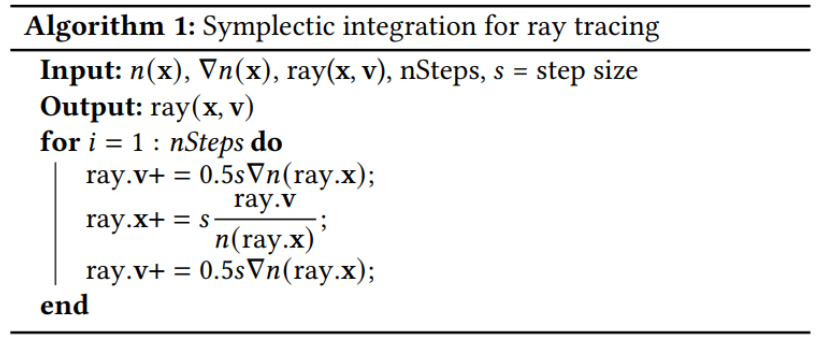

### Parameters
* `ray`: The incoming ray primarily used to determine the initial ray direction and other ray properties to pass on to the intermediate and outgoing rays.
* `hit`: The hit, only used to determine the starting position of the curved ray path.
* `circle`: Stores the circle center, radius, and $p$ parameter for Luneburg lenses used to determine the index of refraction and its gradient.
* `s`: The step size.
* `rays`: The complete list of all rays to be drawn to which intermediate rays are added.

### Returns:
Updates the list of rays to be drawn. Also returns the outgoing ray from the lens once the position of the intermediate rays passes the radius of the circle so that it can continue to be traced.

In [ ]:
def continuousRefract(ray, hit, circle, s, rays):
  # Constants for this function
  R = circle.r
  p = circle.p

  # To draw the intermediate rays, we store the position before and after each iteration
  x1 = hit.p
  x2 = hit.p

  # The (normalized) direction of the intermediate ray
  d = x2 - x1

  # The current direction of the ray (non-normalized)
  v = ray.d

  # vector from circle center to current position, also serves as normal vector
  h = x2 - circle.c
  r = np.linalg.norm(h) # length of the vector is the current radial position
  h = h/r

  # The current refractive index
  eta = luneburg(p, r, R)

  # Keep looping until we exit the lens
  while r < circle.r + epsilon:
    # The main symplectic integration steps...
    v = v + (0.5 * s * dLuneburg(p, r, R) * h)
    eta = luneburg(p, r, R)
    x2 = x1 + s * v/eta
    v = v + (0.5 * s * dLuneburg(p, r, R) * h)

    # Update the direction of this ray and add it to our drawn rays
    d = x2 - x1
    d = d / np.linalg.norm(d)
    intermediateRay = Ray(x1, d, x2, energy=ray.energy, bounce=ray.bounce, color=ray.color, eta=eta, luneburg=True)
    rays.append(intermediateRay)

    # Update vars
    x1 = x2
    h = x2 - circle.c
    r = np.linalg.norm(h)
    h = h/r

  # return the ray exiting the lens
  return Ray(x2, d, energy=ray.energy, bounce=ray.bounce, color=ray.color, eta=eta)



## Testing

It's always a good idea to test these functions and make sure they are doing what we expect. Here, we have a few very basic tests for reflection and refraction. Notably, one advantage of this particular ray tracer is that we can also see exactly what our rays are doing so we can debug by checking that the rays paths match what we expect.

In [ ]:
def checkArrs(arr1, arr2):
  if np.allclose(arr1, arr2):
    checkCondition(True)
  else:
    checkCondition(False)
    print("--> Returned: " + str(arr1) +", Actual: " + str(arr2))

In [ ]:
def checkCondition(boolean):
  if boolean:
    print("PASS")
  else:
    print("FAIL")

In [ ]:
# Unit tests for ray reflection
# Perpendicular reflection
testRay = Ray(np.array([0, 0]), np.array([1, 0]))
testHit = Hit(1, np.array([1,0]), np.array([-1, 0]))
reflectedRay = reflect(testRay, testHit)
checkArrs(reflectedRay.d, np.array([-1, 0]))

# 45 deg reflection
testRay = Ray(np.array([0, 0]), np.array([1, 1])/np.linalg.norm(np.array([1,1])))
reflectedRay = reflect(testRay, testHit)
checkArrs(reflectedRay.d, np.array([-1, 1])/np.linalg.norm(np.array([-1,1])))

PASS
PASS


In [ ]:
# Unit tests for ray refraction
# If eta = 1 for object, should pass right through regardless of normal direction
testRay = Ray(np.array([0, 0]), np.array([1, 0]))
testHit = Hit(1, np.array([1,0]), np.array([-1, 0]), eta=1)
refractedRay, reflectedRay = refract(testRay, testHit)
checkArrs(refractedRay.d, np.array([1, 0]))

testRay = Ray(np.array([0, 0]), np.array([1, 0]))
testHit = Hit(1, np.array([1,0]), np.array([1, 0]), eta=1)
refractedRay, reflectedRay = refract(testRay, testHit)
checkArrs(refractedRay.d, np.array([1, 0]))

PASS
PASS


## Tracing
The trace function is central to the ray tracing algorithm. It computes the closest hit for a given ray, adds the ray to the list of traced rays, then determines what happens to that ray (reflection, refraction, etc) then recursively calls itself after updating the new ray.

### Parameters:
* `ray`: The input ray that needs to be traced.
* `rays`: The complete list of all traced rays that are going to be drawn.
* `bounceLimit`: The desired bounceLimit for the ray tracer. Usually used to limit computation time.
* `circles`: The list of all circles that rays could intersect with.

### Functionality:
*   **Object Intersection:**
The function iterates through every circle in the scene to determine if the ray intersects with it.
    *   If the ray intersects with multiple objects, it finds the closest intersection point.

*   **Ray Storage:**
Once the closest intersection (if any) is found, the ray, along with its associated data (like intersection point and normal), is stored so that it can be drawn later.

*   **Handling Interactions:**
If the ray intersects with an object and has not exceeded the predefined bounce limit, one of three things can happen:

   * The ray hits a luneburg lens so the `continuousRefract` function is called to trace the intermediate path through the luneburg lens. Then, the outgoing ray from the lens is traced.
   * The ray hits a circle that only has mirror reflections (denoted by the circle having a negative index of refraction) so only the reflected ray is traced.
   * The ray hits a transparent circle in which case the `refract` function is called which may return both a reflected and refracted ray which are both traced.

*   **Recursion:**
The recursive nature of the trace function allows it to model multiple interactions (bounces) of a ray as it reflects and refracts through the scene.
   *   The recursion terminates when a ray doesn't intersect with any object or exceeds the bounce limit.

###Returns:
The function returns the updated list of rays so they can be drawn.

In [ ]:
def trace(ray, rays, bounceLimit, circles):
  # Iterate through every circle and update the closest hit
  # Also store whether the closest hit circle has a non-continuous refractive index (determined by whether the hit has a circle defined)
  closestHit = Hit()
  luneburg = False
  for circle in circles:
    hit = circleIntersect(ray, circle, circles)
    if hit.t < closestHit.t:
      closestHit = hit
      luneburg = False if circle.p == 0 else True

  # Add the previous ray to our list of traced rays
  ray.e = ray.o + ray.d * closestHit.t # Note: can't use hit.p since some rays do not intersect with anything!
  rays.append(ray)

  # If we hit something, determine if we should reflect, refract, or continuously refract then trace the resulting ray
  if (closestHit.t < INF and ray.bounce < bounceLimit):
    if luneburg:
      trace(continuousRefract(ray, closestHit, closestHit.circle, 1, rays), rays, bounceLimit, circles)
    else:
      if closestHit.eta < 0: # Mirror reflection
        trace(reflect(ray, closestHit), rays, bounceLimit, circles)
      else:
        refractedRay, reflectedRay = refract(ray, closestHit)
        if refractedRay is not None: trace(refractedRay, rays, bounceLimit, circles)
        if reflectedRay is not None: trace(reflectedRay, rays, bounceLimit, circles)

  # Return the updated list of rays
  return rays

## Ray generation and tracing

Rays can be initialized via two different types of light sources. Directional lights produce parallel rays evenly space about some origin that all head in the given direction. The width of the beam of the rays and the number of rays can be specified. Spot lights produce rays that eminate from a given origin evenly spaced in a cone going in a provided direction. The angular extent of the cone of rays can be provided in radians as well as the number of rays.

For both types of light sources, the number of bounces allowed for rays eminating from that source can be specified as well.

In [ ]:
# Create and trace a set of parallel rays originating from the left and moving to the right
def traceDirectionalLight(rays=[], origin=np.array([10, 200]), direction=np.array([1,0]), width=380, numRays=100, bounceLimit=8):

  # Normalize the direction vector
  direction = direction/np.linalg.norm(direction)

  # Get the perpendicular vector
  perp = np.array([-direction[1], direction[0]])

  # Determine an even spacing between initial rays
  spacing = width/numRays

  # Determine the (perpendicular) offset from the origin
  delta = -width/2 + spacing/2

  # Generate evenly spaced rays travelling in the specified direction
  for i in range(numRays):
    trace(Ray(origin + delta*perp, direction), rays, bounceLimit, circles)
    delta += spacing

  # Return our initial number of rays and our list of traced rays
  return numRays, rays

In [ ]:
# Trace a set of rays from a given origin in a cone of angle theta in the specified direction
def traceSpotLight(rays=[], origin=np.array([10, 200]), direction=np.array([1, 0]), theta=np.pi/4, numRays=100, bounceLimit=8):

  # Normalize the direction vector
  direction = direction / np.linalg.norm(direction)

  angularSpacing = theta/numRays

  # Let delta be the angular displacement of the current ray
  delta = (angularSpacing - theta)/2

  # Generate and Trace the rays
  for i in range(numRays):
    # Rotate the given direction vector by some angle delta
    rotationMatrix = np.array([[np.cos(delta), -np.sin(delta)],[np.sin(delta), np.cos(delta)]])
    thisDirection = rotationMatrix @ direction
    trace(Ray(origin, thisDirection), rays, bounceLimit, circles)
    delta += angularSpacing

  # Return our initial number of rays and our list of traced rays
  return numRays, rays

# Visualization

The render function determines the size of the canvas and handles drawing all rays and circles. To use it, provide the list of circles and rays, the initial number of rays (to determine the opacity scaling for the rays), the width and height of the canvas, and a boolean for if the background should be dark. Note that `darkModed` is False by default to create a white background that provides better contrast for dimmer rays that are reflected/refracted due to Fresnel terms.

In [ ]:
def render(circles, rays, numRays, width, height, darkMode=False):

  # Determine the size of the figure (maintain aspect ratio)
  aspectRatio = width / height
  figSize = (12 * aspectRatio, 12)

  if darkMode:
    plt.style.use('dark_background')
  else:
    plt.style.use('default')

  # Render all circles and rays using matplotlib
  fig, ax = plt.subplots(figsize=figSize)

  plt.xlim([0, width])
  plt.ylim([0, height])

  # Draw all circles
  for circle in circles:
    circlePatch = plt.Circle(circle.c, circle.r, fc=circle.color)
    plt.gca().add_patch(circlePatch)

  # Draw all ray segments
  for ray in rays:
    alpha = ray.energy/np.log10(numRays+10)
    if ray.luneburg: alpha /= 2 # since adjacent intermediate rays in luneburg lenses will overlap
    line = plt.Line2D((ray.o[0], ray.e[0]), (ray.o[1], ray.e[1]), c=ray.color, alpha=alpha) # Note Line2D format for end points: (x0, x1), (y0, y1)
    plt.gca().add_line(line)

  plt.show()

## Initializing Bounds and Circles

The pixel `width` and `height` of the image are defined.

The (optional) global `bounce_limit` is set. Once a ray path exceeds the bounce limit, no further rays along that path are traced.

The circles are added to the `circles` array, which will later be plotted on the image. Feel free to add more circles as desired. Note: while circles are allowed to overlap, doing so may cause erroneous behavior with the current setup as the current design of this ray tracer was not designed for it.

Remember, a circle can be defined by providing the position as a tuple, the radius, and the index of refraction (i.e., eta). If you want a luneburg lens, specify a `p` value instead of `eta`.

In [ ]:
width = 800
height = 400

# Add circles
# You can unncomment some of the circles or make your own!
circles = []

## Three refraftive lenses
# circles.append(Circle((60, 340), 40, eta = 1.05)) # Top left circle
# circles.append(Circle((200, 200), 100, eta = 1.5)) # Middle large circle
# circles.append(Circle((60, 60), 40, eta = 0.7)) # Bottom left circle

## Single large luneburg lens
# circles.append(Circle((200, 200), 100, p=4)) # Centered Luneburg lens

## Three different luneburg lenses followed by three refractive lenses
circles.append(Circle((200, 300), 50, p=3))
circles.append(Circle((200, 200), 50, p=2))
circles.append(Circle((200, 100), 50, p=1))
circles.append(Circle((440, 340), 40, eta = 1.05)) # Top left circle
circles.append(Circle((500, 200), 100, eta = 1.5)) # Middle large circle
circles.append(Circle((440, 60), 40, eta = 0.7)) # Bottom left circle


## Rendering the result

Finally, we can put it all together! If you want to trace multiple light sources, initialize a seperate `rays` list and pass that in. Once all light sources are traced by calling either `traceDirectionalLight` or `traceSpotLight`, you can render the result by calling `render` and passing in the list of circles and rays, the total number of initial rays, and the size of the canvas.

Please, feel free to play with these settings! Add more lights in different directions and sizes and more circles with different properties.

Note: the slowest part of this whole process is actually rendering the final image, especially for Luneburg lenses when there may be hundreds of intermediate rays to be drawn. Pyplot was definitely not intended to be used this way and is consqeuntly pretty slow.

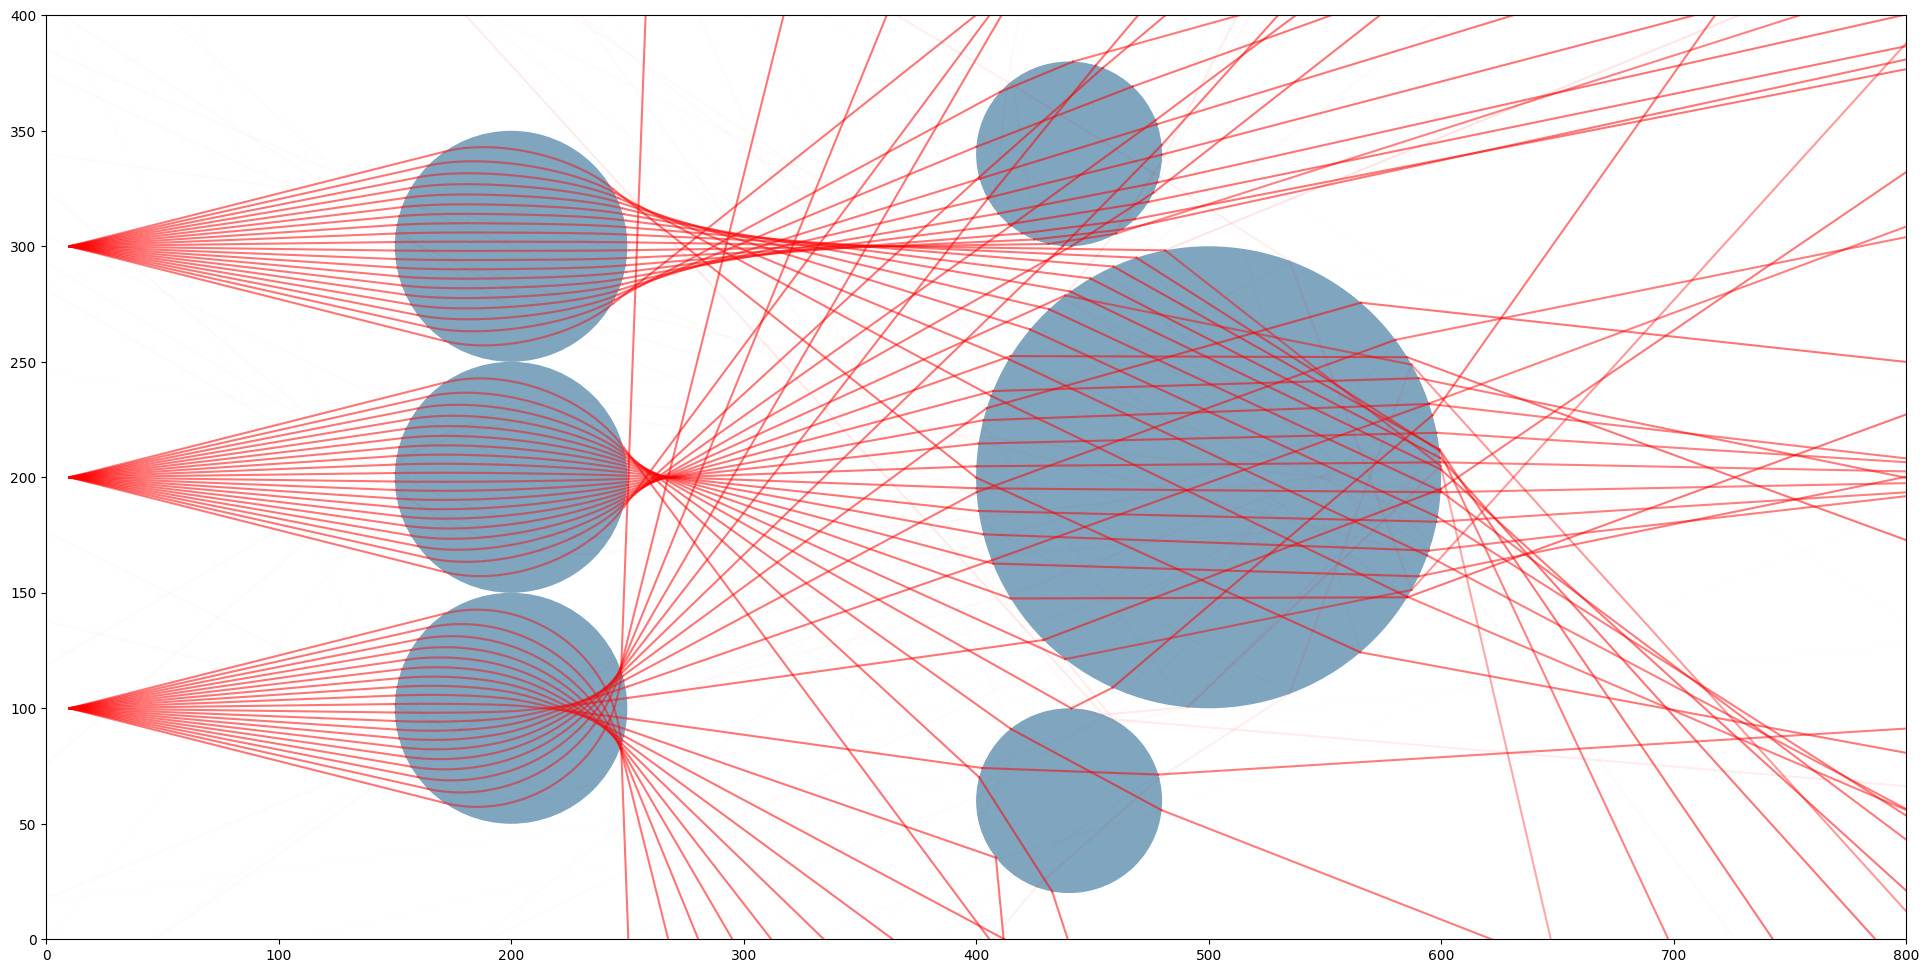

In [ ]:
rays = []
numRays0, rays = traceSpotLight(rays=rays, origin=np.array([10, 100]), direction=np.array([1, 0]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays1, rays = traceSpotLight(rays=rays, origin=np.array([10, 200]), direction=np.array([1, 0]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays2, rays = traceSpotLight(rays=rays, origin=np.array([10, 300]), direction=np.array([1, 0]), theta=np.pi/6, numRays=20, bounceLimit=8)
render(circles, rays, numRays0+numRays1+numRays2, width, height)

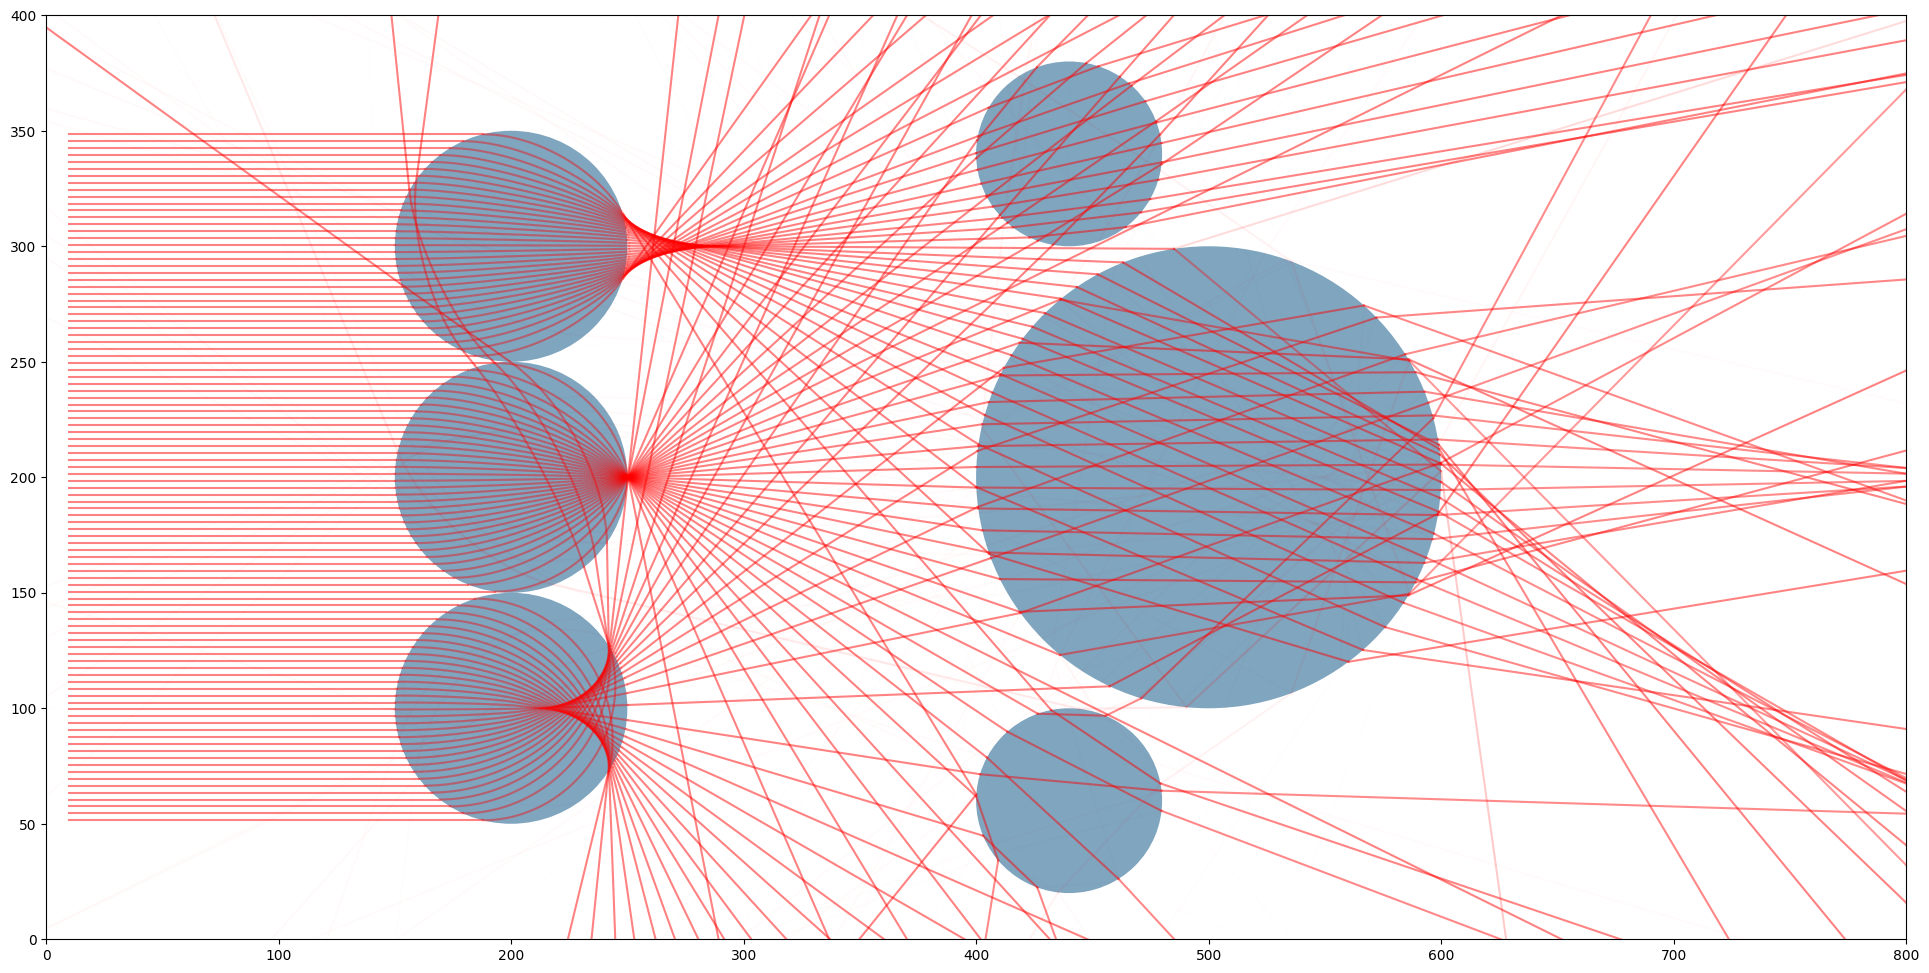

In [ ]:
numRays, rays = traceDirectionalLight(rays=[], origin=np.array([10, 200]), direction=np.array([1,0]), width=300, numRays=100, bounceLimit=8)
render(circles, rays, numRays, width, height)

When we have spherical lenses with constant indices of refraction, we can see how the foci of the lenses depend on their index of refraction. We also see *spherical abberation* as the parallel light rays are not being focused to a point but instead to a range of points and the width of this abberation increases as the refractive index gets closer to 1. Finally, we also see that when the refractive index is less than 1, the rays diverge. Ofcourse, this is not exactly physically possible since that would mean light is travelling faster than in a vaccuum but this phenomenon can still happen, if, say the surrounding medium is water and the light is passing through an air bubble that has a lower refractive index.

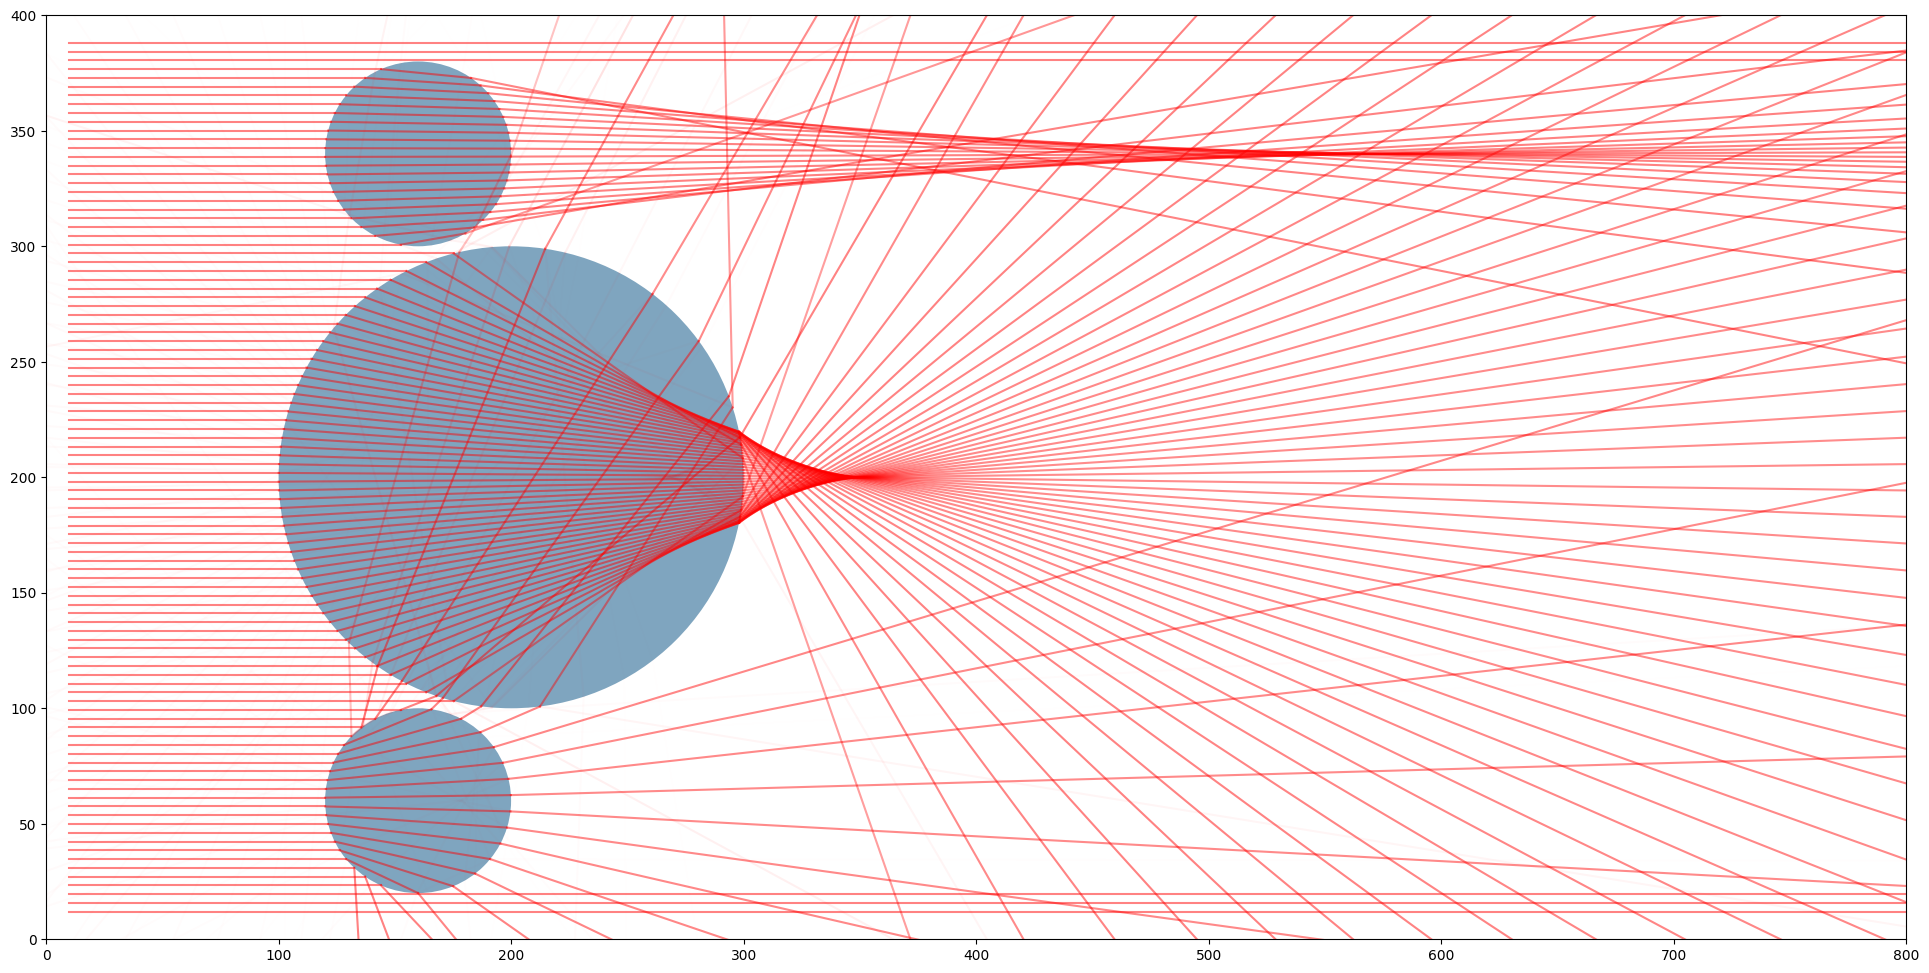

In [ ]:
circles = []

# Three refractive lenses
circles.append(Circle((160, 340), 40, eta = 1.05)) # Top left circle
circles.append(Circle((200, 200), 100, eta = 1.5)) # Middle large circle
circles.append(Circle((160, 60), 40, eta = 0.7)) # Bottom left circle

numRays, rays = traceDirectionalLight(rays=[], origin=np.array([10, 200]), direction=np.array([1,0]), width=380, numRays=100, bounceLimit=8)
render(circles, rays, numRays, width, height)

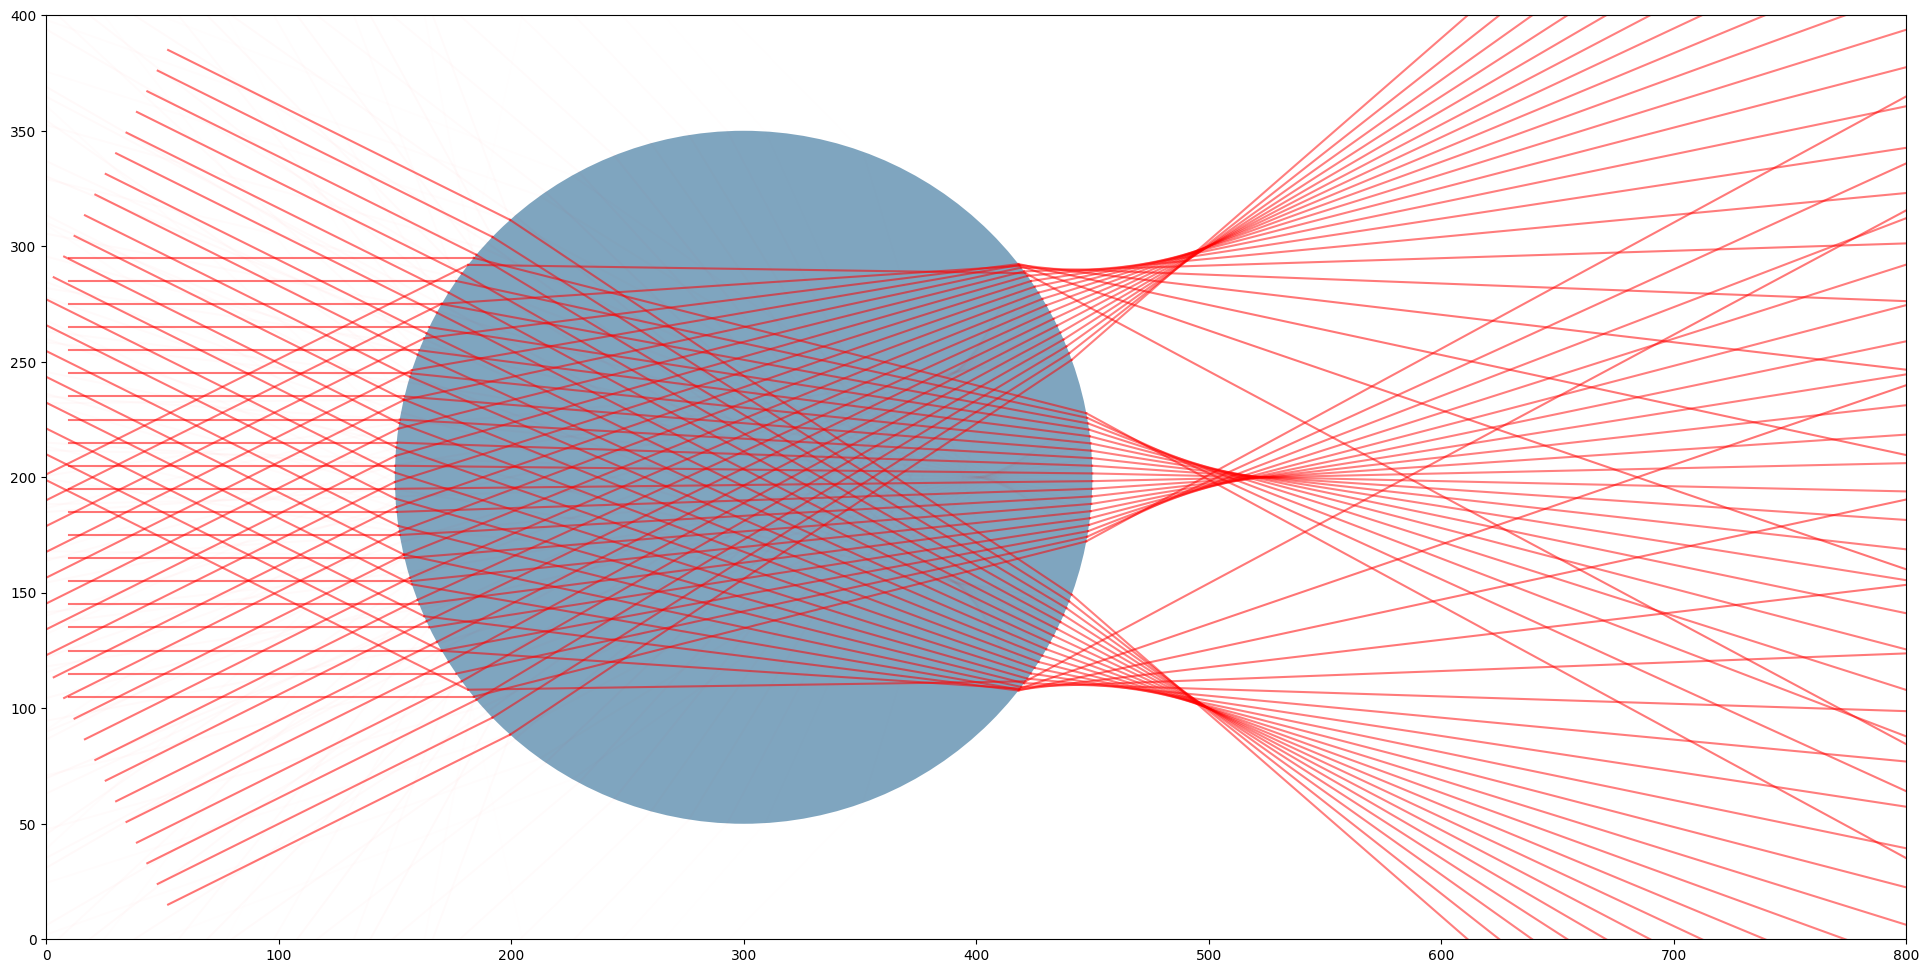

In [ ]:
circles = []
circles.append(Circle((300, 200), 150, eta = 1.5)) # Middle large circle

rays = []
numRays0, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 100]), direction=np.array([1,0.5]), width=200, numRays=20, bounceLimit=8)
numRays1, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 200]), direction=np.array([1,0]), width=200, numRays=20, bounceLimit=8)
numRays2, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 300]), direction=np.array([1,-0.5]), width=200, numRays=20, bounceLimit=8)
render(circles, rays, numRays0+numRays1+numRays2, width, height)

This example showcases the effect of Fresnel terms. Here, you can see the faint internally reflected rays showing up that then exit out of the back of the lens. You can also seem them in the other images but again, they are really faint for these particular examples! (If you want, modify the `refract` function so that the rays are not scaled by their Fresnel coefficients and you'll see all sorts of cool cardioid patterns!)

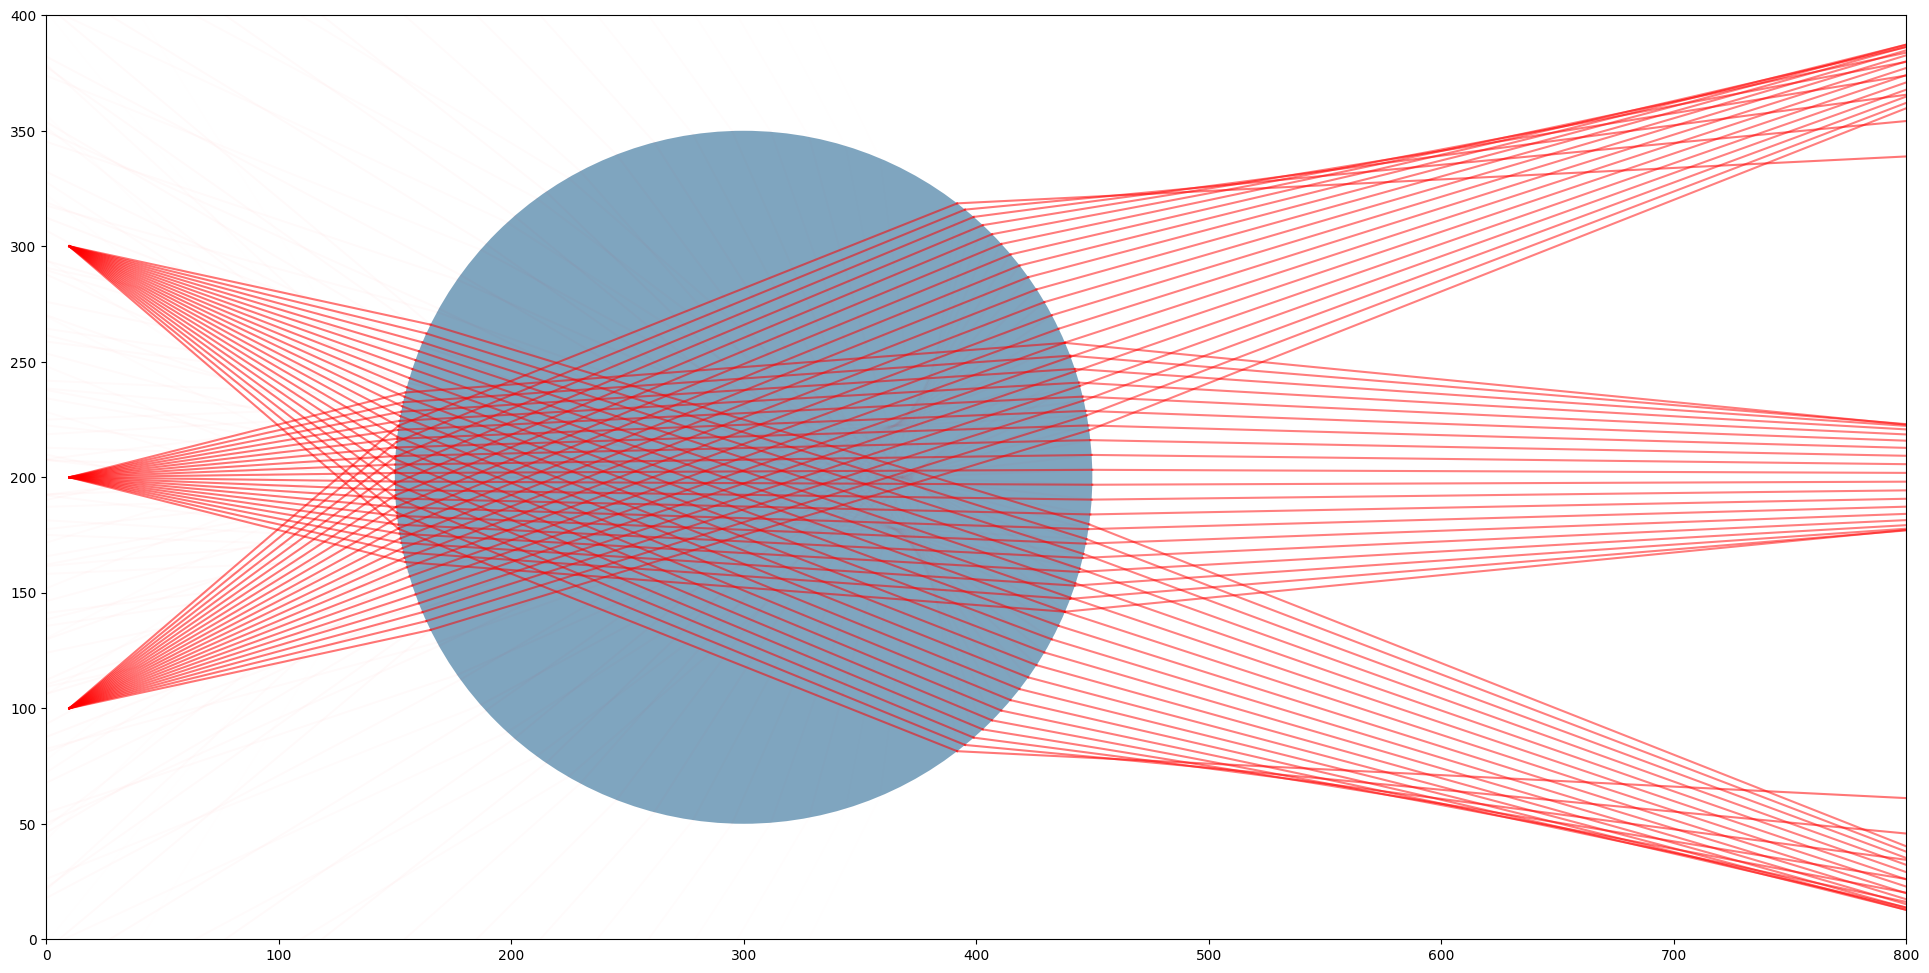

In [ ]:
rays = []
numRays0, rays = traceSpotLight(rays=rays, origin=np.array([10, 100]), direction=np.array([1, 0.5]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays1, rays = traceSpotLight(rays=rays, origin=np.array([10, 200]), direction=np.array([1, 0]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays2, rays = traceSpotLight(rays=rays, origin=np.array([10, 300]), direction=np.array([1, -0.5]), theta=np.pi/6, numRays=20, bounceLimit=8)
render(circles, rays, numRays0+numRays1+numRays2, width, height)

An interesting property of a Luneburg lens with $p=2$ is that the foci of parallel rays are always at the surface of the lens regardless of incoming direction!

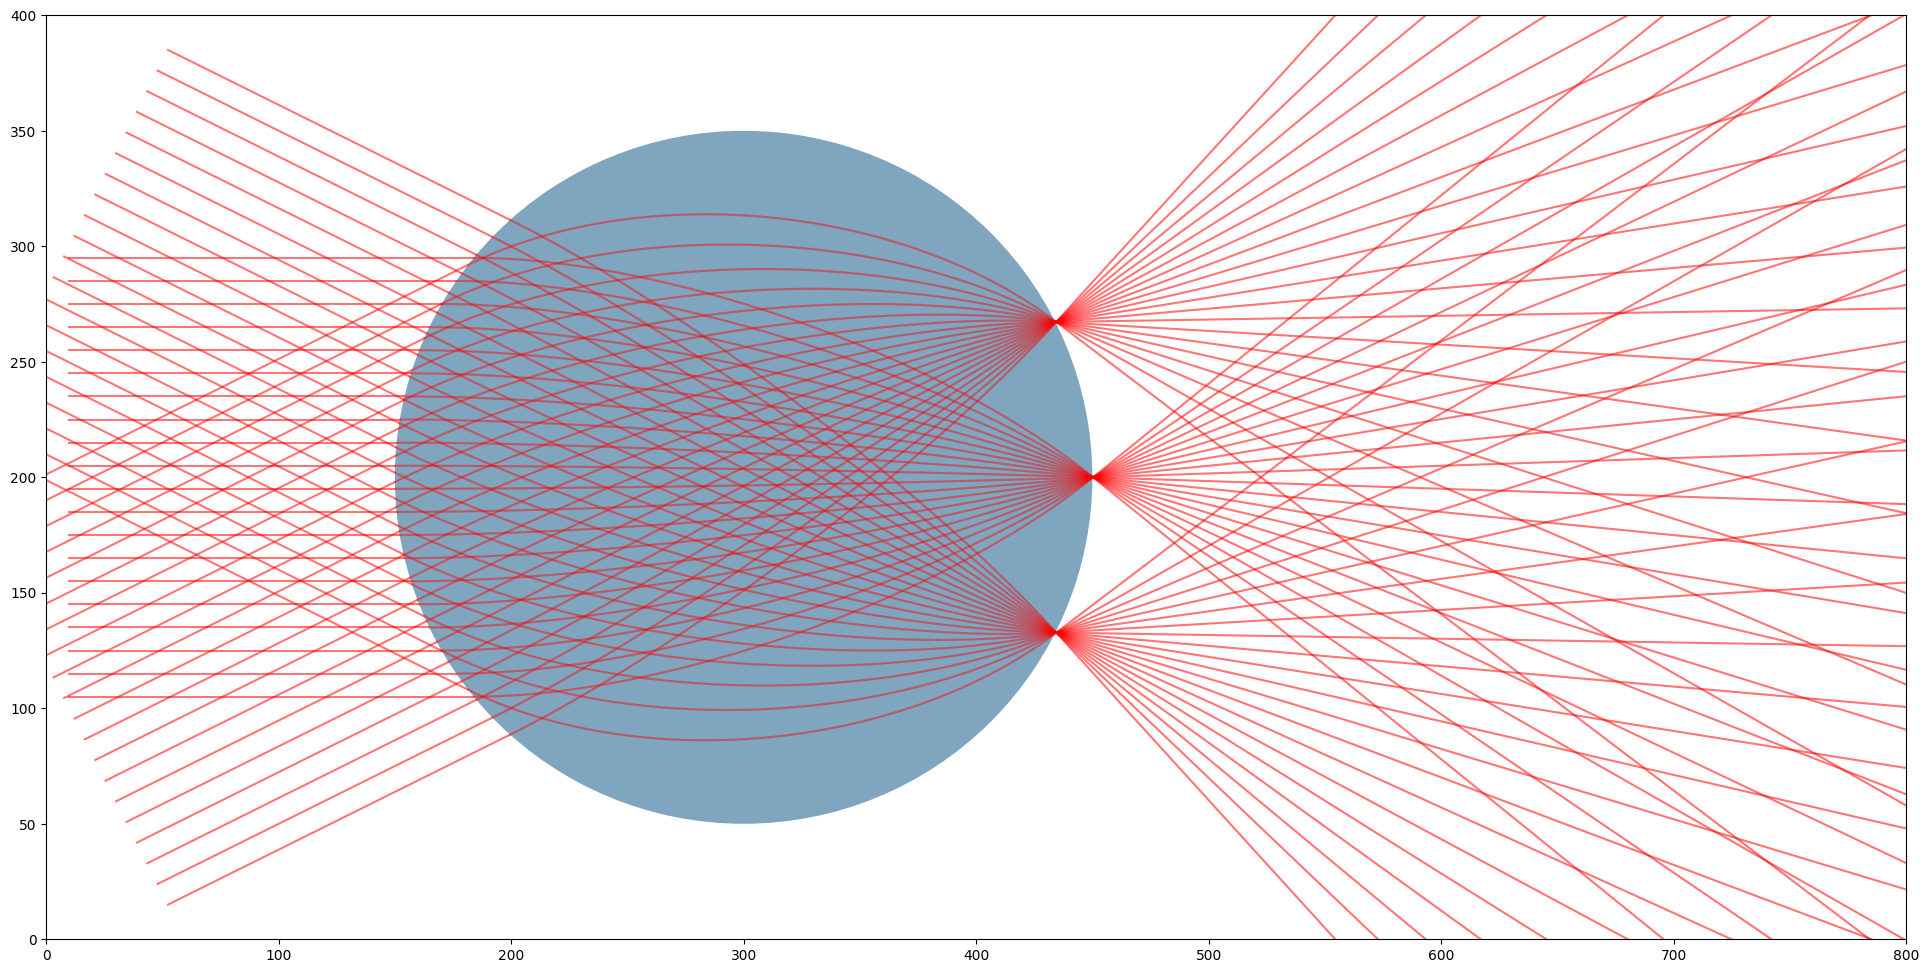

In [ ]:
circles = []
circles.append(Circle((300, 200), 150, p = 2))

rays = []
numRays0, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 100]), direction=np.array([1,0.5]), width=200, numRays=20, bounceLimit=8)
numRays1, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 200]), direction=np.array([1,0]), width=200, numRays=20, bounceLimit=8)
numRays2, rays = traceDirectionalLight(rays=rays, origin=np.array([10, 300]), direction=np.array([1,-0.5]), width=200, numRays=20, bounceLimit=8)
render(circles, rays, numRays0+numRays1+numRays2, width, height)

However, non-parallel rays still have a focus outside of the lens.

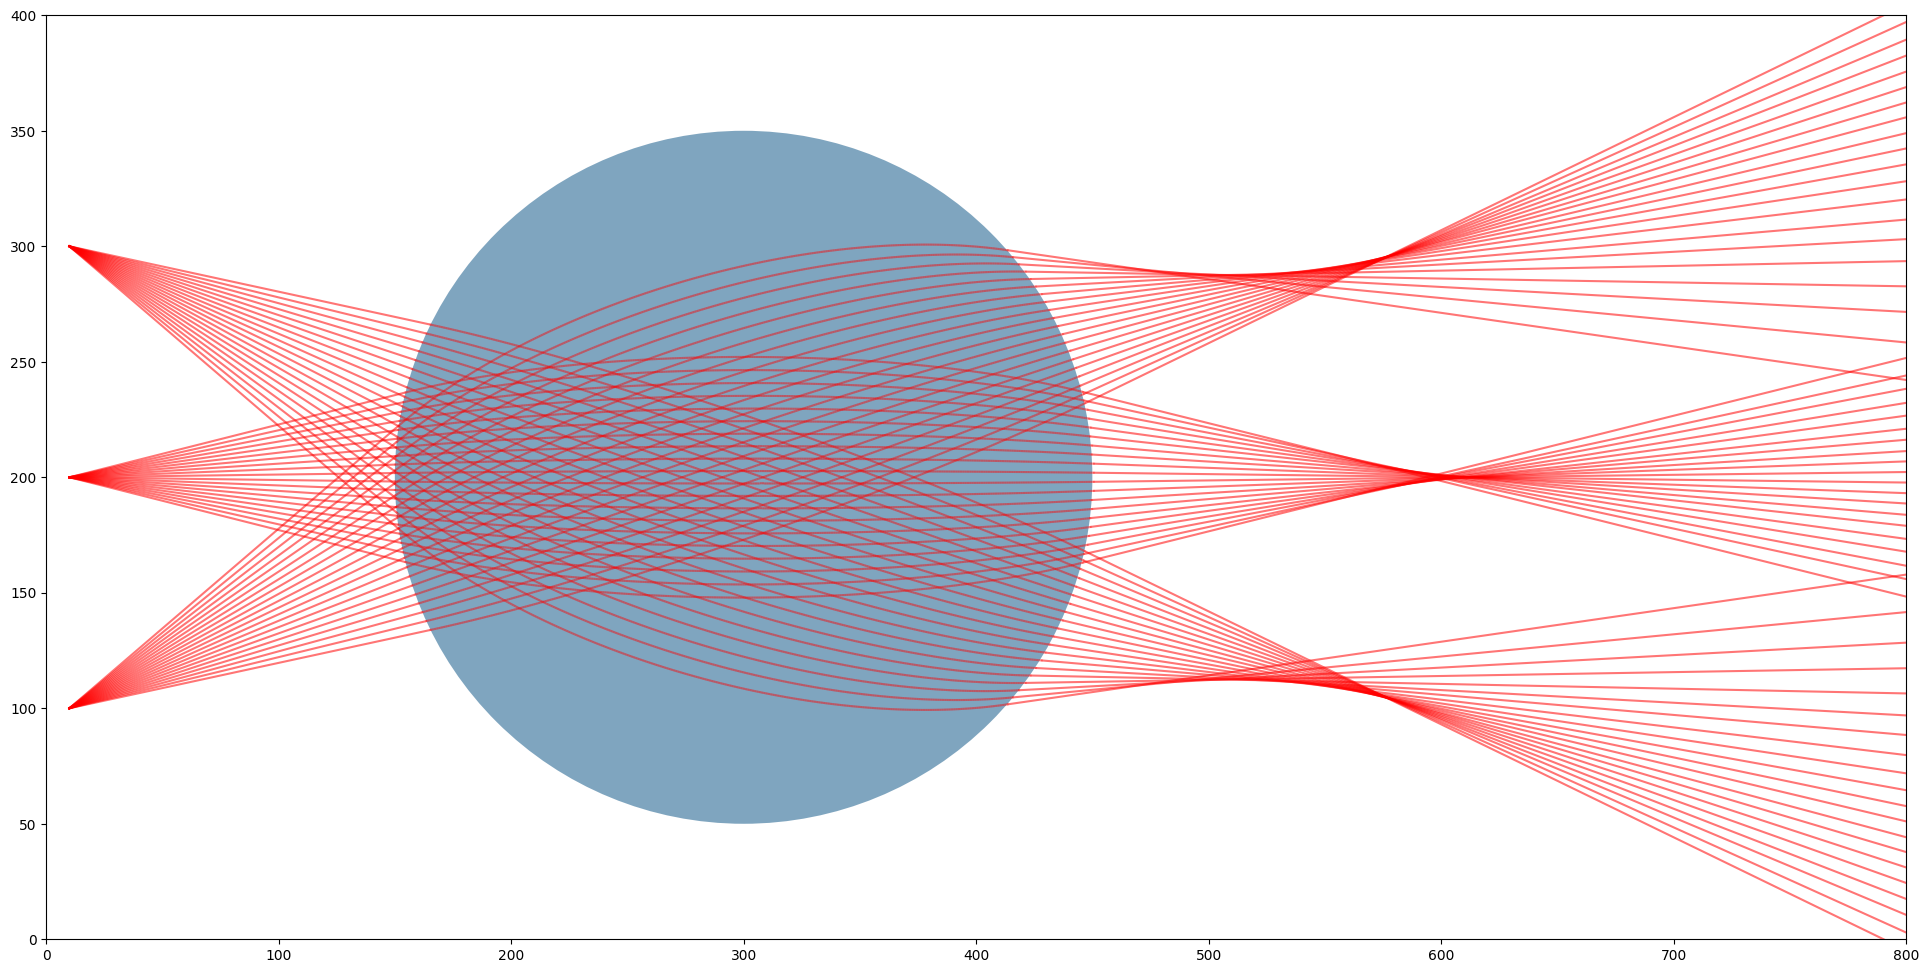

In [ ]:
rays = []
numRays0, rays = traceSpotLight(rays=rays, origin=np.array([10, 100]), direction=np.array([1, 0.5]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays1, rays = traceSpotLight(rays=rays, origin=np.array([10, 200]), direction=np.array([1, 0]), theta=np.pi/6, numRays=20, bounceLimit=8)
numRays2, rays = traceSpotLight(rays=rays, origin=np.array([10, 300]), direction=np.array([1, -0.5]), theta=np.pi/6, numRays=20, bounceLimit=8)
render(circles, rays, numRays0+numRays1+numRays2, width, height)